# Vehicle detection project

### Necessary module import

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
# from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

%matplotlib inline

### Data set loading

In [2]:
vehicle_imgs = glob.glob('vehicles/**/*.png')
nonv_imgs = glob.glob('non-vehicles/**/*.png')

#sample = 500 #Testing size
#vehicle_imgs = vehicle_imgs[0:sample]
#nonv_imgs = nonv_imgs[0:sample]

print(len(vehicle_imgs), len(nonv_imgs))

8792 8968


As the data set seems to be balanced, there has not been applied any data set augmentation technic 

### Data set properties and example visualization

8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


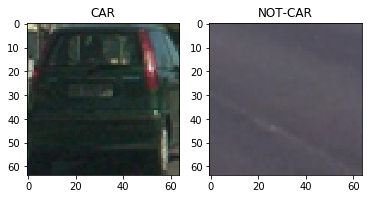

In [3]:
cars = []
notcars = []

for image in vehicle_imgs:
        cars.append(image)
        
for image in nonv_imgs:
        notcars.append(image)
        
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    '''
    Provided by Udacity in classroom
    '''
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print(data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('CAR')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('NOT-CAR')

 ### Define the classroom functions developed during the project module

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))
                        
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

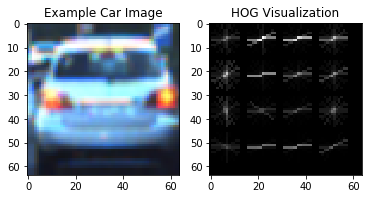

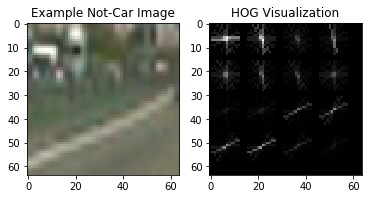

In [5]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

image_non = mpimg.imread(notcars[ind])
gray_non = cv2.cvtColor(image_non, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 11
pix_per_cell = 15
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

features, hog_non = get_hog_features(gray_non, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

fig = plt.figure()
plt.subplot(121)
plt.imshow(image_non, cmap='gray')
plt.title('Example Not-Car Image')
plt.subplot(122)
plt.imshow(hog_non, cmap='gray')
plt.title('HOG Visualization')

### Feature extraction and Support Vector Machine training

In [6]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
spatial_size = (32,32)
hist_bins = 16
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(cars, color_space=colorspace,spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False, hog_feat=True)
notcar_features = extract_features(notcars, color_space=colorspace,spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_feat=False, hist_feat=False, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)  

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

### CLASSIFIER TRAINING ###

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

47.84 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
1.15 Seconds to train SVC...
Test Accuracy of SVC =  0.9811
My SVC predicts:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  0.  1.  1.  1.  0.  0.]
0.00186 Seconds to predict 10 labels with SVC


 ### Modified find_cars function implementation

In [7]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, orient, 
              pix_per_cell, cell_per_block, demo):
    
    # array of rectangles where cars were detected
    detections = []
    
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]
    
    # Sliding-window search
    
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1 
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1   
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) -  1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or demo:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                detections.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                
    return detections

In [8]:
test_img = mpimg.imread('./test_images/test1.jpg')

ystart = 400
ystop = 660 
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

detections = find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, orient, pix_per_cell, cell_per_block, False)

print(len(detections), 'detections found in image')

4 detections found in image


### Draw boxes function implementation

In [9]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

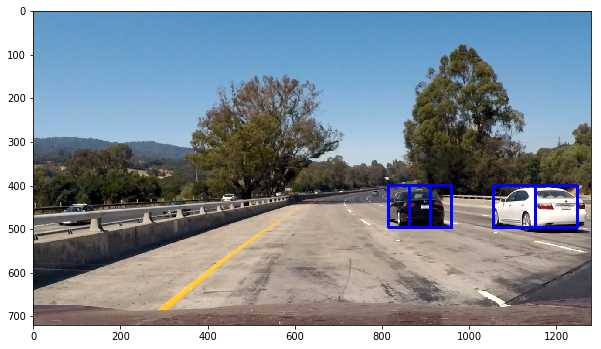

In [10]:
test_img_rects = draw_boxes(test_img, detections)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)

### Sliding window method implementation for different scale and search regions

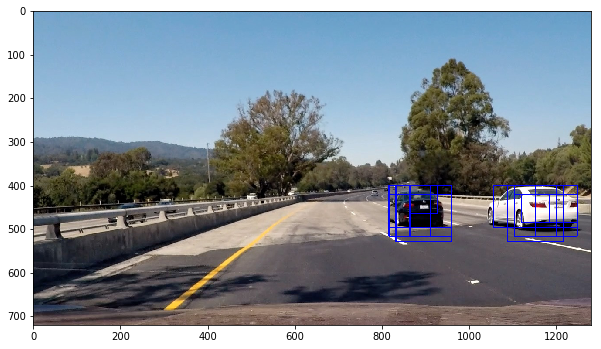

In [11]:
test_img = mpimg.imread('./test_images/test4.jpg')

detections = []

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"


ystart = 400
ystop = 464
scale = 1.0
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))
ystart = 420
ystop = 484
scale = 1.0
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))
ystart = 400
ystop = 496
scale = 1.5
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))
ystart = 420
ystop = 516
scale = 1.5
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))
ystart = 400
ystop = 528
scale = 2.0
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))

ystart = 430
ystop = 558
scale = 2.0
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                        orient, pix_per_cell, cell_per_block, False))
    
ystart = 440
ystop = 568
scale = 2.5
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                       orient, pix_per_cell, cell_per_block, False))
ystart = 410
ystop = 606
scale = 3.0
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,
                       orient, pix_per_cell, cell_per_block, False))
ystart = 430
ystop = 654
scale = 3.5
detections.append(find_cars(test_img, ystart, ystop, scale, colorspace, hog_channel, svc,
                       orient, pix_per_cell, cell_per_block, False))

# apparently this is the best way to flatten a list of lists
detections = [item for sublist in detections for item in sublist] 
test_img_rects = draw_boxes(test_img, detections, color=(0,0,255), thick=2)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)


### Heat map implementation for false positive filtering

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

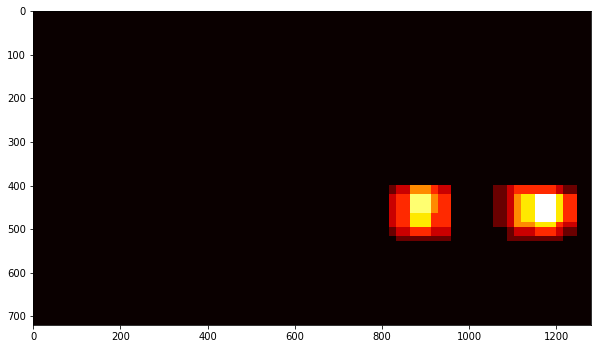

In [13]:
# Test out the heatmap
heatmap_img = np.zeros_like(test_img[:,:,0])
heatmap_img = add_heat(heatmap_img, detections)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')

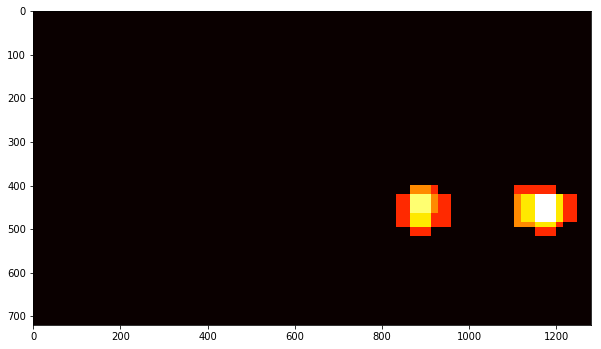

In [14]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

heatmap_img = apply_threshold(heatmap_img, 2)
plt.figure(figsize=(10,10))
plt.imshow(heatmap_img, cmap='hot')


2 cars found


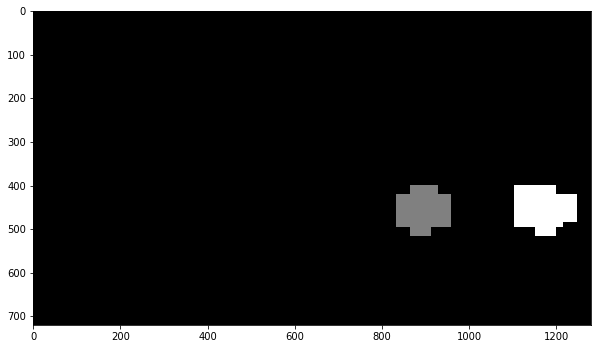

In [15]:
labels = label(heatmap_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
print(labels[1], 'cars found')

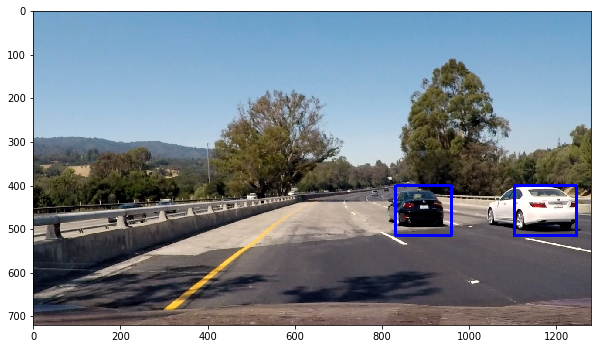

In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    rects = []
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image and final detections
    return img, rects

# Draw bounding boxes on a copy of the image
draw_img, rect = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.figure(figsize=(10,10))
plt.imshow(draw_img)


### Define a class to store previous detections and "weight" the heatmap treshold

In [17]:
class Vehicles():
    def __init__(self):
        # history of detections previous n frames
        self.prev_boxes = [] 
        
    def add_box(self, rects):
        self.prev_boxes.append(rects)
        if len(self.prev_boxes) > 25:
            # throw out oldest rectangle set(s)
            self.prev_boxes = self.prev_boxes[len(self.prev_boxes)-25:]

### Video processing pipeline

In [18]:
def process_video(img):
    
    detections = []

    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    ystart = 400
    ystop = 464
    scale = 1.0
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 420
    ystop = 484
    scale = 1.0
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 400
    ystop = 496
    scale = 1.5
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 420
    ystop = 516
    scale = 1.5
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 400
    ystop = 528
    scale = 2.0
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))

    ystart = 430
    ystop = 558
    scale = 2.0
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                            orient, pix_per_cell, cell_per_block, False))
    
    ystart = 440
    ystop = 568
    scale = 2.5
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, 
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 410
    ystop = 606
    scale = 3.0
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc,
                           orient, pix_per_cell, cell_per_block, False))
    ystart = 430
    ystop = 654
    scale = 3.5
    detections.append(find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc,
                           orient, pix_per_cell, cell_per_block, False))


    detections = [item for sublist in detections for item in sublist] 
    
    # add detections to the history
    if len(detections) > 0:
        box.add_box(detections)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in box.prev_boxes:
        heatmap_img = add_heat(heatmap_img, rect_set)
    heatmap_img = apply_threshold(heatmap_img, 2 + len(box.prev_boxes)//2)
     
    labels = label(heatmap_img)
    draw_img, rect = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img


# Video procesing

In [ ]:
box = Vehicles()
test_out_file2 = 'test_video_out.mp4'
clip_test2 = VideoFileClip('test_video.mp4')
clip_test_out2 = clip_test2.fl_image(process_video)
%time clip_test_out2.write_videofile(test_out_file2, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:11<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 9.88 s, sys: 2.12 s, total: 12 s
Wall time: 12.2 s


In [ ]:
box = Vehicles()
proj_out_file = 'project_video_out.mp4'
clip_proj = VideoFileClip('project_video.mp4')
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


 99%|█████████▉| 1250/1261 [06:42<00:03,  2.94it/s]